***
## Библиотеки и исходные данные. 

In [15]:
import warnings 
warnings.filterwarnings("ignore")

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots

from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [17]:
# добавим обводку нашим графикам
plt.rcParams["patch.force_edgecolor"] = True

Для начала давайте познакомимся с нашими данными:

In [18]:
data = pd.read_csv(
    'data/customer_segmentation_project.csv', 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Размер датасета: {}'.format(data.shape))
data.head(5)

Размер датасета: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* *InvoiceNo* — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* *Stock Code* — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* *Description* — название товара;
* *Quantity* — количество каждого товара за транзакцию; 
* *InvoiceDate* — дата и время выставления счёта/проведения транзакции;
* *UnitPrice* — цена за единицу товара в фунтах стерлингов;
* *CustomerID* — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* *Country* — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы:

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [20]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Посмотрим на пропуски:

In [21]:
data.isna().mean().sort_values(ascending=False)

CustomerID     0.249267
Description    0.002683
InvoiceNo      0.000000
StockCode      0.000000
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
Country        0.000000
dtype: float64

Примерно четверть всех идентификаторов клиента - пропуски. Разберёмся с ними позже.

Теперь преобразуем столбец ***InvoiceDate*** в формат *datetime*:

In [22]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

***
## Предобработка и очистка данных.

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


Начнем с пропусков. Примем, что пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях, поэтому мы их удалим:

In [23]:
print(f'Количество удалённых наблюдений: {data.isna().sum().sum()}')
data = data.dropna()

Количество удалённых наблюдений: 136534


Теперь посмотрим на наличие дубликатов:

In [24]:
data.duplicated().sum()

5225

Удалим их:

In [25]:
data = data.drop_duplicates()

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [26]:
negative_quantity = data[(data['Quantity']<0)]
print('Количество записей с отрицательным количеством товаров: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Количество записей с отрицательным количеством товаров: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


При просмотре таблицы можно заметить следующее:
- Номер заказа (*InvoiceNo*) и код товара (*StockCode*) могут содержать не только числа, но и символы.
- Как было сказано в описании датасета, символ **"C"** перед номером заказа указывает на возврат. То есть, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа **"C"** и c положительным количеством товара.
- Код товара может содержать различные специальные символы: например, символ **"D"**, судя по описанию товара (столбец *Description*), означает наличие скидки.
- Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция.

Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом:

In [28]:
negative_quantity['FalseReturn'] = negative_quantity['InvoiceNo'].apply(lambda x: 1 if x[0] != 'C' else 0)
print(f'Количество транзакций с отрицательным количество товаров, не являющихся возвратами: {negative_quantity.FalseReturn.sum()}')

Количество транзакций с отрицательным количество товаров, не являющихся возвратами: 0


Отлично! Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов. Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент-заказ»:

In [29]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу *nb_products_per_basket* признак отмены заказа (*order_canceled*): он равен 1, если транзакция является возвратом, и 0 — в противном случае:

In [30]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)

Давайте поближе взглянем на отмененные заказы:


In [31]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Для примера найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:

In [32]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена».

Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица *data*) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара:

In [33]:
for _, col in negative_quantity.iterrows():   
    mask_1 = data['CustomerID'] == col['CustomerID']
    mask_2 = data['Quantity'] == -col['Quantity']
    mask_3 = data['StockCode'] == col['StockCode']
    if data[mask_1 & mask_2 & mask_3].shape[0] == 0: 
        print(col)
        print('\nНаша гипотеза не верна!')
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                   14527
Country             United Kingdom
FalseReturn                      0
Name: 141, dtype: object

Наша гипотеза не верна!


Давайте разбираться, на чём "споткнулась" наша гипотеза. Посмотрим на клиента с идентификатором 14527:

In [34]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица *data*) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки:

In [35]:
negative_quantity_no_discount = negative_quantity[negative_quantity['StockCode'] != 'D']

for _, col in negative_quantity_no_discount.iterrows():   
    mask_1 = data['CustomerID'] == col['CustomerID']
    mask_2 = data['Quantity'] == -col['Quantity']
    mask_3 = data['StockCode'] == col['StockCode']    
    if data[mask_1 & mask_2 & mask_3].shape[0] == 0: 
        print(col)
        print('\nНаша гипотеза не верна!')
        break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
FalseReturn                                  0
Name: 154, dtype: object

Наша гипотеза не верна!


Посмотрим, где кроется наша проблема. Давайте посмотрим на транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:

In [36]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


Рассмотрим повнимательнее:
* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак *QuantityCanceled*, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

Реализуем функцию *get_quantity_canceled()*. Она принимает на вход таблицу с транзакциями и возвращает объект *Series* — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец *QuantityCanceled*:

In [37]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace=True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара:

In [38]:
data = data[data['Quantity'] > 0]
print(f'Размер датасета: {data.shape}')

Размер датасета: (392732, 9)


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак *StockCode* обозначен как **'D'**. Давайте проверим, бывают ли другие специальные коды:

In [39]:
mask = data['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)
data.loc[mask, 'StockCode'].nunique()

6

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы:

In [40]:
data = data[~mask]
print(f'Размер датасета: {data.shape}')

Размер датасета: (391183, 9)


Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. Посмтрим сколько их:

In [41]:
data[data['UnitPrice'] == 0].count()

InvoiceNo           33
StockCode           33
Description         33
Quantity            33
InvoiceDate         33
UnitPrice           33
CustomerID          33
Country             33
QuantityCanceled    33
dtype: int64

Таких транзакций оказалось менее 1%, поэтому от них можно просто избавиться:

In [42]:
data = data[data['UnitPrice'] != 0]
print(f'Размер датасета: {data.shape}')

Размер датасета: (391150, 9)


***
## Разведочный анализ данных.

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


Для начала выясним, в каких странах живут клиенты:

In [43]:
data_country = data[['CustomerID', 'Country']]
data_country = data_country.drop_duplicates()

uniq_clients = data_country.groupby('Country').count()
uniq_clients.sort_values(by='CustomerID', ascending=False).head(10)

,CustomerID
Country,
United Kingdom,3916
Germany,94
France,87
Spain,30
Belgium,25
Switzerland,21
Portugal,19
Italy,14
Finland,12


Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов? Построим визуализацию и выделим топ-5 стран по количеству поступающих заказов:

In [44]:
data_country = data[['InvoiceNo', 'Country']]
data_country = data_country.drop_duplicates()

uniq_clients = data_country.groupby('Country').count()
uniq_clients.sort_values(by='InvoiceNo', ascending=False).head(5)

,InvoiceNo
Country,
United Kingdom,16579
Germany,443
France,379
EIRE,256
Belgium,98


Давайте добавим в датасет общую цену заказа, назовём её ***TotalPrice***.

Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [45]:
data['TotalPrice'] = (data['Quantity'] - data['QuantityCanceled']) * data['UnitPrice'] 

Построим визуализацию и выделим топ-5 стран, клиенты из которых приносят компании больше всего выручки:

In [48]:
piv_rev = data.groupby(['Country'])['TotalPrice'].sum()
px.choropleth(
    piv_rev,
    locations=piv_rev.index,
    locationmode='country names',
    color=piv_rev.values
)

In [49]:
piv_rev.sort_values(ascending=False).head()

Country
United Kingdom    6797691.44
Netherlands        283443.54
EIRE               247074.57
Germany            201520.71
France             181529.63
Name: TotalPrice, dtype: float64

Теперь займёмся временными характеристиками.

Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки. Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам:

In [50]:
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.day_of_week
data['Hour'] = data['InvoiceDate'].dt.hour

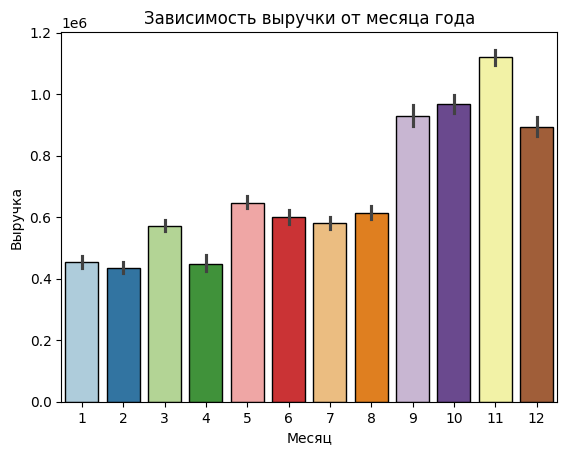

In [52]:
sns.barplot(data=data, x='Month', y='TotalPrice', estimator='sum', palette=sns.color_palette('Paired'))

plt.title('Зависимость выручки от месяца года')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

Максимальная выручка в магазине случается в ноябре. Поскольку клиенты нашего магазина в основном оптовики, то логично предположить, что в ноябре происходит массовая закупка перед праздниками в конце года.

Построим визуализацию количества заказов для каждого дня недели:

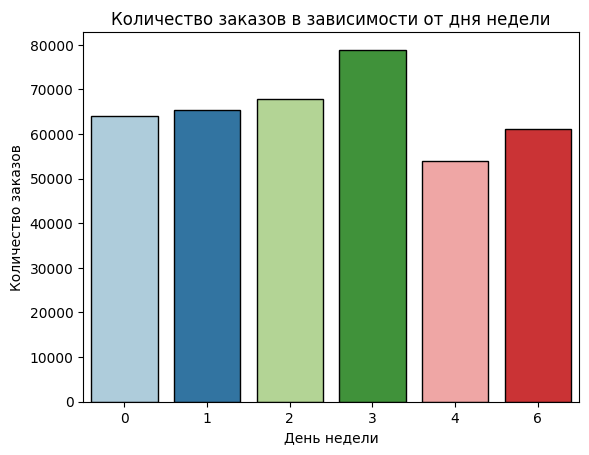

In [54]:
sns.countplot(data=data, x='DayOfWeek', palette=sns.color_palette('Paired'))

plt.title('Количество заказов в зависимости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов');

Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

Выделим дату из признака времени совершения транзакции. Сгруппируем данные по датам и часам совершения транзакции и найдём количество заказов на каждый **день-час**, а затем найдём среднее количество ежедневно поступающих заказов в каждый из часов:

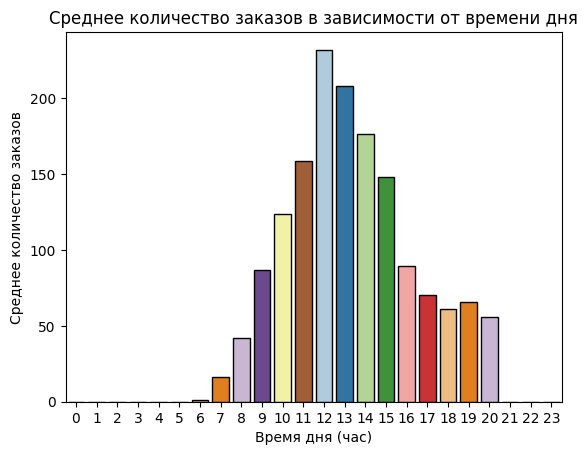

In [55]:
data['Date'] = data['InvoiceDate'].dt.date

piv_date = data.groupby(['Date', 'Hour'])['CustomerID'].count()
piv_date = piv_date.reset_index(level=[0,1])

order_hour = {}

for h in range(0, 24):
    if h in piv_date['Hour'].unique():
        order_hour[h] = piv_date[piv_date['Hour'] == h]['CustomerID'].mean()
    else:
        order_hour[h] = 0

order_hour = pd.DataFrame(order_hour.values(), index=order_hour.keys(), columns=['MeanOrderCount'])

sns.barplot(data=order_hour, x=order_hour.index, y=order_hour['MeanOrderCount'], palette=sns.color_palette('Paired'))

plt.title('Среднее количество заказов в зависимости от времени дня')
plt.xlabel('Время дня (час)')
plt.ylabel('Среднее количество заказов');

***
## *RFM*-сегментация клиентов. Часть 1.

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов. Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием **RFM**. 

Метод заключается в группировке клиентов на основе следующих параметров:
* *Recency* (Давность) — давность последней покупки клиента;
* *Frequency* (Частота) — общее количество покупок клиента;
* *Monetary Value* (Денежная ценность) — сколько денег потратил клиент.

Суть *RFM*-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

![img-2](\images\rfm-1.png)

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать *RFM*-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Итак, приступим к созданию нашей *RFM*-таблицы. Чтобы получить *RFM*-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* *Recency* для *i*-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения *i*-ым клиентом своей *j*-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате *datetime* — '2011-12-10 00:00:00').

* *Frequency* рассчитывается как общее количество уникальных заказов, которые совершил *i*-ый клиент.
* *Monetary Value* рассчитывается как общая сумма денег, которую *i*-ый клиент потратил на наши товары (с учетом возвратов).

In [72]:
data['Recency'] = pd.Timestamp('2011-12-10 00:00:00') - data['InvoiceDate']
data['Recency'] = data['Recency'].dt.days

In [73]:
piv_rec = data.groupby('CustomerID')['Recency'].min()
piv_monet = data.groupby('CustomerID')['TotalPrice'].sum()
piv_freq = data.pivot_table(values='InvoiceNo', index='CustomerID', aggfunc=lambda x: len(x.unique()))

rfm_table = pd.concat([piv_rec, piv_freq, piv_monet], axis=1)
rfm_table = rfm_table.rename(columns={'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'})
rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


Посмотрим, сколько заказов в среднем делает клиент (за представленный годовой период):

In [74]:
print(f'Среднее количество заказов клиента за год: {rfm_table.Frequency.mean():.2f}')

Среднее количество заказов клиента за год: 4.25


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [75]:
color_list = [['red'], ['green'], ['blue']]
boxes = [px.box(rfm_table, x=column, color_discrete_sequence=color_list[i]) for i, column in enumerate(rfm_table.columns)]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        'Recency (Давность)', 'Frequency (Частота)', 'Monetary (Денежная ценность)'
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show();

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма *KMeans*, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов:

In [76]:
mask_1 = rfm_table['Frequency'] <= rfm_table['Frequency'].quantile(0.95)
mask_2 = rfm_table['Monetary'] <= rfm_table['Monetary'].quantile(0.95)

rfm_table_cleaned = rfm_table[mask_1 & mask_2]
print(f'Количество уникальных клиентов после очистки: {rfm_table_cleaned.shape}')

Количество уникальных клиентов после очистки: (4044, 3)


Взглянем ещё раз на коробчатые диаграммы:

In [77]:
boxes = [px.box(rfm_table_cleaned, x=column, color_discrete_sequence=color_list[i]) for i, column in enumerate(rfm_table_cleaned.columns)]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        'Recency (Давность)', 'Frequency (Частота)', 'Monetary (Денежная ценность)'
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show();

***
## Кластеризация. Часть 1.

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


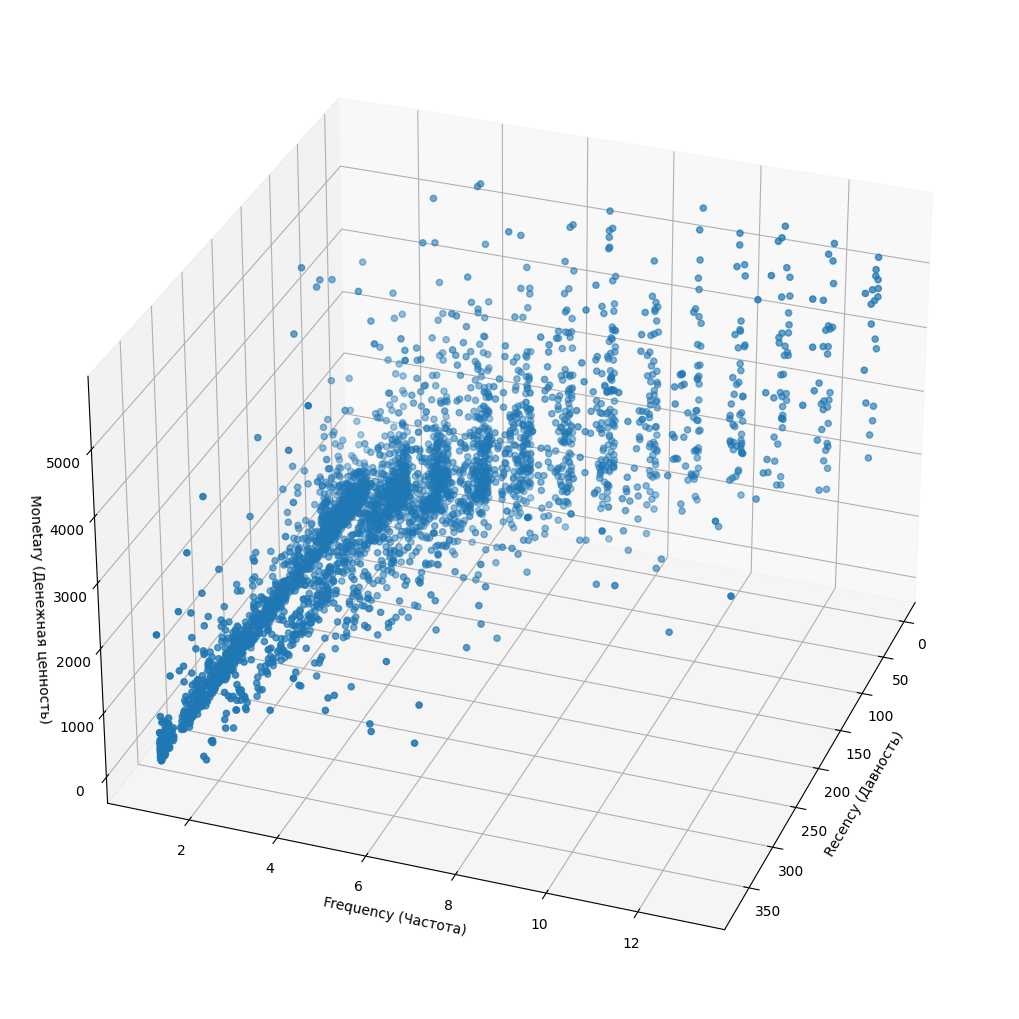

In [78]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)

ax.set_xlabel('Recency (Давность)')
ax.set_ylabel('Frequency (Частота)')
ax.set_zlabel('Monetary (Денежная ценность)');

Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров *Monetary* и *Frequency* — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть.

#### Метод главных компонент (*PCA*)

Давайте попробуем методы снижения размерности. Начнём с метода главных компонент (*PCA*). Таким образом, данные необходимо стандартизировать.

Создадим *pipeline*, в котором будут следующие шаги:
* стандартизация с помощью *StandardScaler* с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

In [81]:
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)

rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['pca_1', 'pca_2'])

Посмотрим на долю объяснённой дисперсии для получившихся компонент:

In [82]:
pipeline['pca'].explained_variance_ratio_

array([0.67747053, 0.24012744])

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

Text(0.5, 1.0, 'Пространство главных компонент (n=2)')

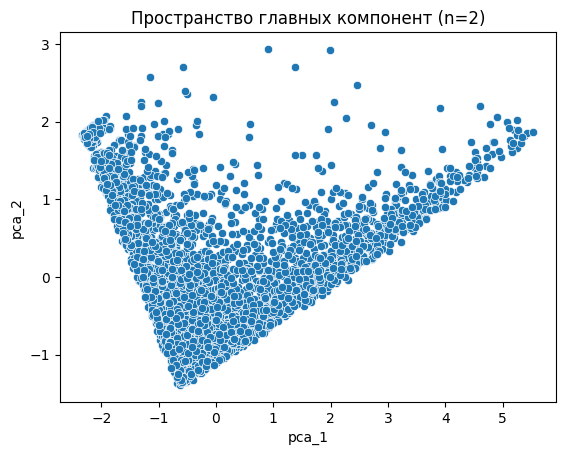

In [83]:
sns.scatterplot(data=rfm_table_processed, x='pca_1', y='pca_2');

plt.title('Пространство главных компонент (n=2)')

Попробуем разделить это пространство главных компонент на сегменты. 

Воспользуемся методом [**K-means**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

Подберём оптимальное количество кластеров с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно:

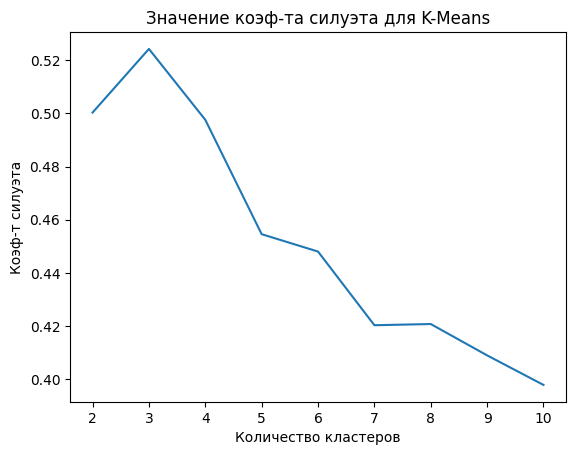

In [90]:
silhouette = {}

for cluster in range(2, 11):
    model_ = KMeans(n_clusters=cluster, random_state=42)
    model_.fit(rfm_table_processed)

    silhouette[cluster] = silhouette_score(rfm_table_processed, model_.labels_)

sns.lineplot(x=silhouette.keys(), y=silhouette.values())

plt.title('Значение коэф-та силуэта для K-Means')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэф-т силуэта');

Оптимальное количество кластеров - 3.

Теперь возьмём [*EM*-алгоритм](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

Подберём оптимальное количество кластеров с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно:

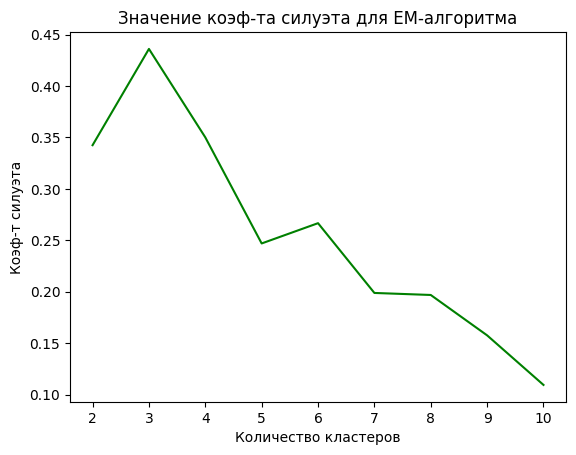

In [91]:
gauss_mixt = {}

for cluster in range(2, 11):
    model_ = GaussianMixture(n_components=cluster, random_state=42)
    model_.fit(rfm_table_processed)

    gauss_mixt[cluster] = silhouette_score(rfm_table_processed, model_.predict(rfm_table_processed))

sns.lineplot(x=gauss_mixt.keys(), y=gauss_mixt.values(), color='g')

plt.title('Значение коэф-та силуэта для EM-алгоритма')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэф-т силуэта');

И опять получили то же самое оптимальное количество кластеров - 3.

Давайте посмотрим на распределение кластеров.

Сначала нужно определить лучшую модель. Возьмём модель с наибольшим значением коэффициента силуэта - это будет **K-Means**. Обучим эту модель с подобранным ранее количеством кластеров на декомпозированных данных:

In [93]:
model_best = KMeans(n_clusters=3, random_state=42)
model_best.fit(rfm_table_processed)

labels_ = pd.DataFrame(model_best.labels_, columns=['labels'])

rfm_table_processed = pd.concat([rfm_table_processed, labels_], axis=1)
rfm_table_processed

,pca_1,pca_2,labels
0,-2.135201,1.401596,0
1,3.447125,0.852872,1
2,0.629103,0.083217,2
3,0.152932,-0.720954,2
4,-1.888765,1.382645,0
...,...,...,...
4039,-0.873840,-0.729007,2
4040,-1.805975,1.051772,0
4041,-1.421026,0.168347,0
4042,-0.319330,-1.198285,2


Визуализируем результаты кластеризации:

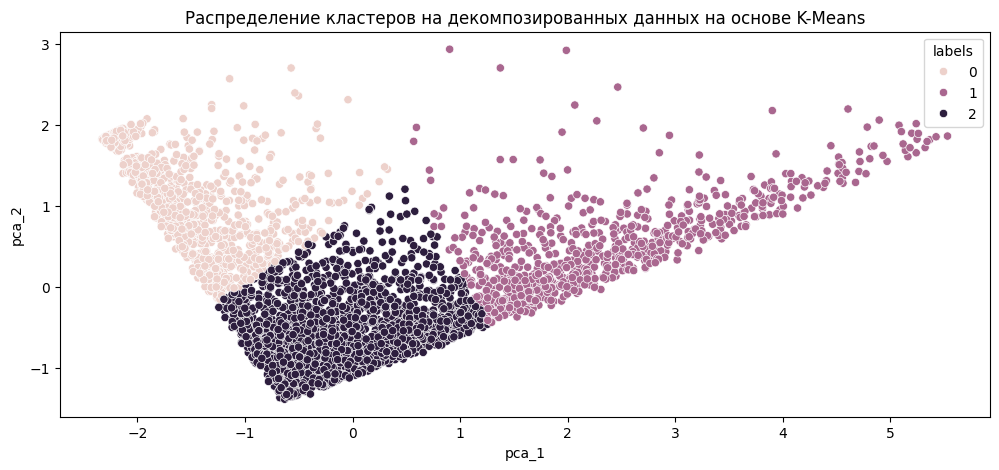

In [94]:
fig = plt.figure(figsize=(12,5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='pca_1', 
    y='pca_2', 
    hue='labels',
)

plt.title('Распределение кластеров на декомпозированных данных на основе K-Means');

Посмотрим на количество клиентов в каждом из кластеров в цифрах:

In [95]:
cnt = Counter(model_best.labels_)
cnt

Counter({0: 999, 1: 776, 2: 2269})

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к *RFM*-таблице, очищенной от выбросов. Сгруппируем *RFM*-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков:

In [96]:
labels_ = labels_.set_index(rfm_table_cleaned.index)
rfm_table_cleaned = pd.concat([rfm_table_cleaned, labels_], axis=1)

piv_clust = rfm_table_cleaned.groupby('labels')[['Recency', 'Frequency', 'Monetary']].mean()
piv_clust

,Recency,Frequency,Monetary
labels,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — *Radar Chart* (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
*Radar Chart* очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (*Music*), а в меньшей степени — программированием (*Programm*).

В модуле *graph_objects* библиотеки *plotly* есть встроенная функция *Scatterpolar*, которая позволяет построить полярную диаграмму. На основе этой функции мы реализуем собственную функцию *plot_cluster_profile()*, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: *grouped_data* — сгруппированные по кластерам характеристики объектов (клиентов), *n_clusters* — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавим в реализацию функции *plot_cluster_profile()*.

In [97]:
def plot_cluster_profile(grouped_data, n_clusters):
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    fig = go.Figure()
    for i in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название признаков
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))

    fig.update_layout(
        showlegend=True,
        autosize=False,
        width=1024,
        height=1024,
    )

    fig.show();    

Визуализируем профили кластеров в виде полярной диаграммы на основе средних *RFM*-характеристик, вычисленных для каждого кластера:

In [98]:
plot_cluster_profile(piv_clust, 3)

Итак, что мы видим:
- **Кластер 1** соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
- **Кластер 2** соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
- **Кластер 0** соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

***
## *RFM*-сегментация клиентов. Часть 2.

Итак, с помощью *RFM*-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Ранее мы производили кластеризацию в пространстве главных компонент. Однако *PCA* является линейным методом отображения исходного пространства признаков в его сжатую версию. А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности *t-SNE*. Давайте попробуем и посмотрим, что получится.

Воспользуемся алгоритмом *t-SNE* и трансформируем *RFM*-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в *pipeline*:
1. Стандартизация с помощью *StandardScaler* с параметрами по умолчанию; 
2. Алгоритм *t-SNE* с двумя компонентами, параметрами *perplexity*=50 и *random_state*=100.

Обучите наш *pipeline* на *RFM*-таблице (очищенной от выбросов):

In [100]:
rfm_table_cleaned = rfm_table_cleaned.drop('labels', axis=1)

pipeline = Pipeline([('scaler', StandardScaler()), ('t-SNE', TSNE(perplexity=50, random_state=100))])
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)

Дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма *t-SNE*. Она показывает меру расстояния между двумя распределениями. Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма *t-SNE*, хранится в атрибуте *kl_divergence_*:

In [108]:
print('Значение дивергенции Кульбака — Лейблера: {0:.2f}'.format(pipeline['t-SNE'].kl_divergence_))

Значение дивергенции Кульбака — Лейблера: 0.54


Визуализировав пространство после декомпозиции с помощью *t-SNE*, мы получим следующую картину:


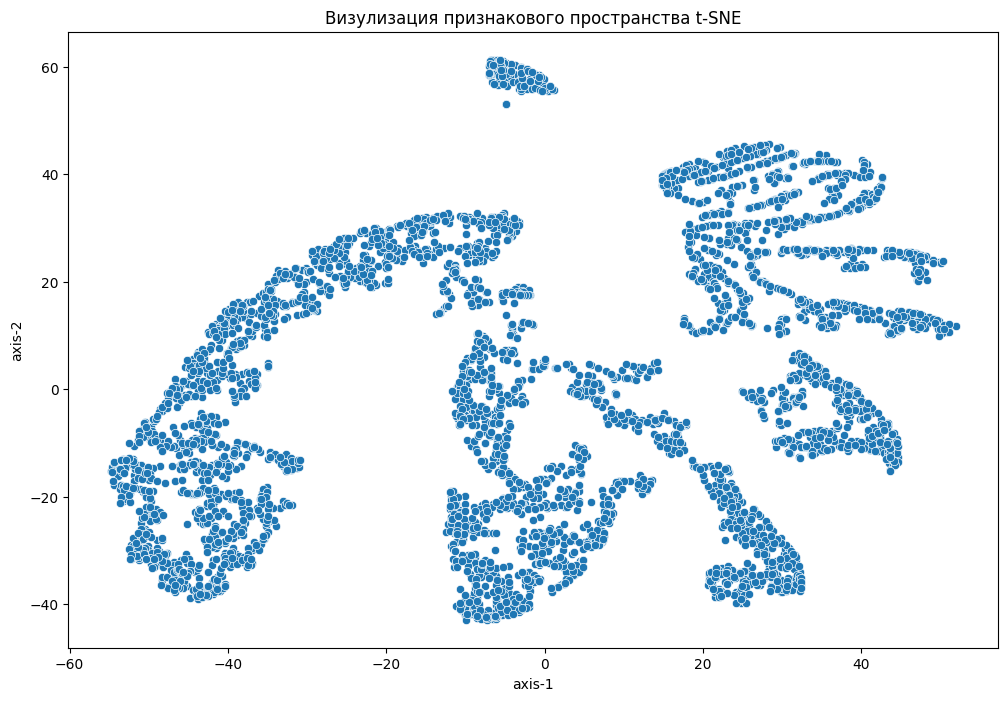

In [109]:
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'])

fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2')

plt.title('Визулизация признакового пространства t-SNE');

Как и ожидалось от *t-SNE*, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить. Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


Попробуем воспользоваться методом *K-means*. Подберём оптимальное количество кластеров:

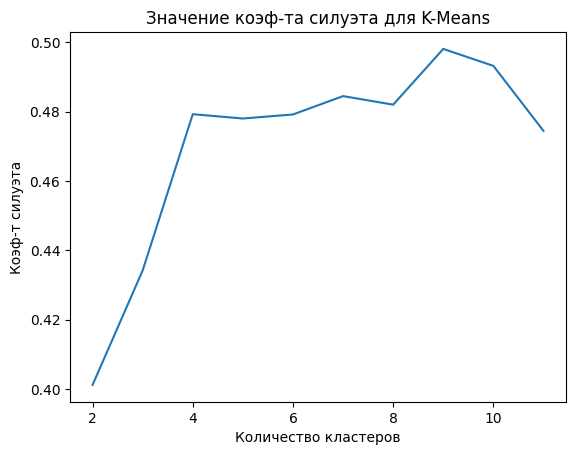

In [127]:
kmeans_ = {}
for cluster in range(2, 12):
    model_ = KMeans(n_clusters=cluster, random_state=42)
    model_.fit(rfm_table_processed)

    kmeans_[cluster] = silhouette_score(rfm_table_processed, model_.labels_)

sns.lineplot(x=kmeans_.keys(), y=kmeans_.values())

plt.title('Значение коэф-та силуэта для K-Means')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэф-т силуэта');

Оптимальное количество кластеров - 9.

Теперь попробуем воспользоваться *EM*-алгоритом:

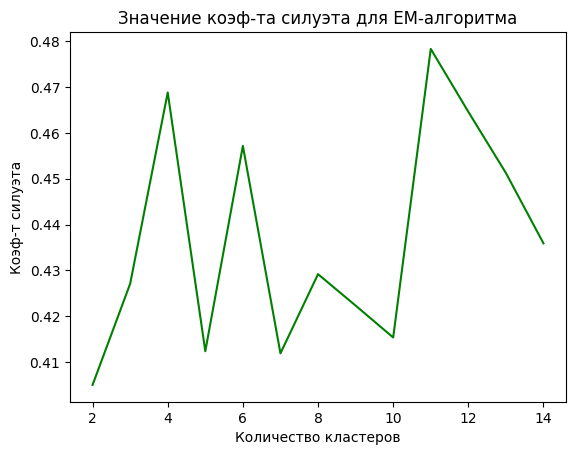

In [128]:
gauss_mixt = {}
for cluster in range(2, 15):
    model_ = GaussianMixture(n_components=cluster, random_state=42)
    model_.fit(rfm_table_processed)

    gauss_mixt[cluster] = silhouette_score(rfm_table_processed, model_.predict(rfm_table_processed))

sns.lineplot(x=gauss_mixt.keys(), y=gauss_mixt.values(), color='g')

plt.title('Значение коэф-та силуэта для EM-алгоритма')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэф-т силуэта');

Оптимальное количество кластеров - 11.

Наконец, попробуем воспользоваться алгоритмом агломеративной кластеризации (*AgglomerativeClustering*):

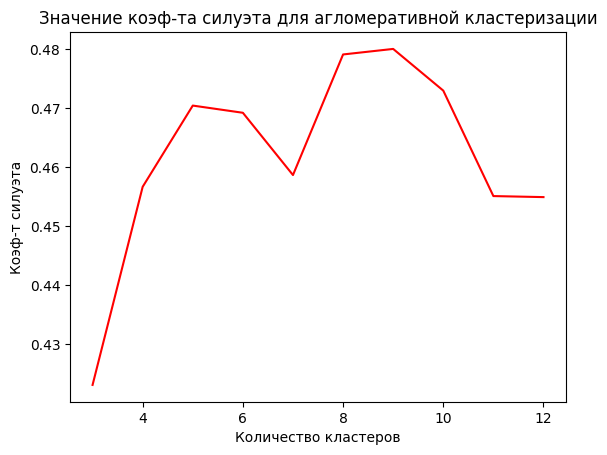

In [129]:
agg_clust = {}
for cluster in range(3, 13):
    model_ = AgglomerativeClustering(n_clusters=cluster)
    model_.fit(rfm_table_processed)

    agg_clust[cluster] = silhouette_score(rfm_table_processed, model_.labels_)

sns.lineplot(x=agg_clust.keys(), y=agg_clust.values(), color='r')

plt.title('Значение коэф-та силуэта для агломеративной кластеризации')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэф-т силуэта');

Оптимальное количество кластеров - 9.

Сначала нужно определить лучшую модель. По нашим результатам, лучшая модель это **K-Means** с количеством кластеров равным 9.

Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных:

In [120]:
model_best = KMeans(n_clusters=9, random_state=42)
model_best.fit(rfm_table_processed)

KMeans(n_clusters=9, random_state=42)

Посмтрим на количество клиентов в кластерах:

In [121]:
cnt = Counter(model_best.labels_)
cnt

Counter({7: 431,
         8: 688,
         3: 539,
         1: 521,
         2: 337,
         6: 448,
         5: 628,
         4: 338,
         0: 114})

Визуализируем результаты кластеризации:

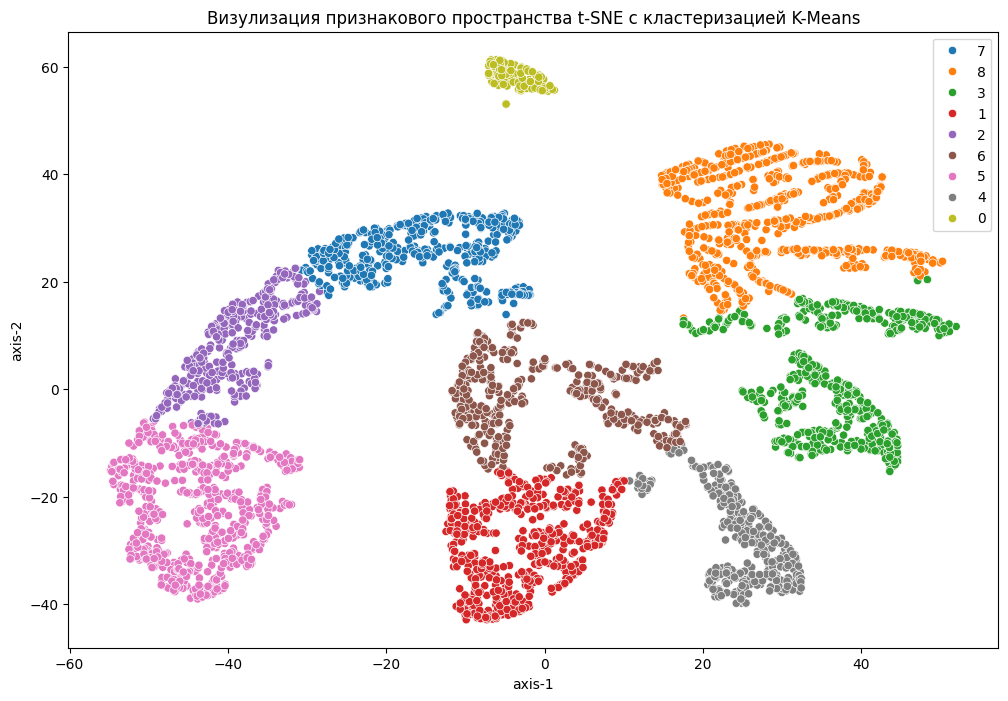

In [122]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model_best.labels_.astype('str'))

plt.title('Визулизация признакового пространства t-SNE с кластеризацией K-Means');

Итак, у нас есть 9 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к *RFM*-таблице, очищенной от выбросов. Сгруппируем *RFM*-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков:

In [123]:
labels_ = pd.DataFrame(model_best.labels_, columns=['labels'])

labels_ = labels_.set_index(rfm_table_cleaned.index)
rfm_table_cleaned = pd.concat([rfm_table_cleaned, labels_], axis=1)

piv_clust = rfm_table_cleaned.groupby('labels')[['Recency', 'Frequency', 'Monetary']].mean()
piv_clust

,Recency,Frequency,Monetary
labels,,,
0,365.456140,1.043860,235.531930
1,37.616123,1.978887,591.651132
2,157.477745,1.000000,270.757300
3,44.743970,4.324675,1294.389184
4,32.281065,2.937870,929.855651
5,44.229299,1.000000,324.685127
6,171.921875,2.544643,693.253460
7,281.519722,1.092807,354.798074
8,27.239826,7.444767,2674.837616


Визуализируем профили кластеров в виде полярной диаграммы на основе средних *RFM*-характеристик, вычисленных для каждого кластера:

In [125]:
plot_cluster_profile(piv_clust, 9)

Итак:
1. **Кластер 8** соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
2. **Кластер 1** соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
3. **Кластер 7** соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
4. **Кластер 6** соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
5. **Кластер 5** соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
6. **Кластер 2** соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
7. **Кластер 0** соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.
8. **Кластер 3** и **Кластер 4** довольно похожи, хотелось бы сделать доп. анализ, но больше всего они походят на перспективных клиентов. 

***
## *RFM*-сегментация клиентов. Часть 3.

Мы построили модель кластеризации для части клиентов. Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью *t-SNE* пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема *t-SNE* заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как *PCA* и *SVD*, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса *TSNE* из библиотеки *sklearn* нет такого метода, как *transform()*, у него есть только метод *fit_transform()* — заново обучить алгоритм *t-SNE* и произвести трансформацию.

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются *RFM*-характеристиками. Давайте обучим модель, которая на основе *RFM*-характеристик будет предсказывать клиентский сегмент.

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20:

In [131]:
X = rfm_table_cleaned.drop('labels', axis=1)
y = rfm_table_cleaned['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Поскольку алгоритм *t-SNE* является нелинейным методом понижения размерности, то можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

#### Случайный лес.

In [137]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

model_ = RandomForestClassifier(random_state=42)

gs = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print('\nЛучшие гиперпараметры: ', gs.best_params_)

rf_best = RandomForestClassifier(random_state=42, **gs.best_params_)
rf_best.fit(X_train, y_train)

y_test_pred = rf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f'Точность на тестовой выборке: {round(accuracy, 3)}')


Лучшие гиперпараметры:  {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}
Точность на тестовой выборке: 0.985


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

In [138]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

model_ = GradientBoostingClassifier(random_state=42)

gs = GridSearchCV(estimator=model_, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print('\nЛучшие гиперпараметры: ', gs.best_params_)

rf_best = GradientBoostingClassifier(random_state=42, **gs.best_params_)
rf_best.fit(X_train, y_train)

y_test_pred = rf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f'Точность на тестовой выборке: {round(accuracy, 3)}')


Лучшие гиперпараметры:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Точность на тестовой выборке: 0.985


Отлично, мы справились с проблемой непараметричности *t-SNE* и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе *RFM*-характерик клиента автоматически определяет его сегмент.